# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#checking any repitition occurs or not
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence, it is necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It can be observed from below check that in the given two rows the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations.

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
# considering those data having helpfulnessdenominator greater than helpfulnessnumerator.
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### OBSERVATION:
1. positive reviews : 307061
2. negative reviews : 57110<br>
We can conclude that the data is IMBALANCED. Hence, we have to do either undersampling or oversampling for model creation.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]        #.values[] is used to get any data from dataframe
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm        
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)     #removing urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()    #removing html tags
    sentance = decontracted(sentance)                       #decontracting words
    sentance = re.sub("\S*\d\S*", "", sentance).strip()     # removing words with number
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)          #removing special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)    # converting to lowercase
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:32<00:00, 1711.35it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

# [5] KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [53]:
#importing important modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [25]:

print(final.shape)
print("*************************************************")

#adding cleaned_text column to the final dataframe
final["cleaned_text"] = preprocessed_reviews

print(final.shape)
print("*************************************************************************************")

#checking if any missing values is present in the reviews.
final = final.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

print(final.shape)

final.head()





(364171, 10)
*************************************************
(364171, 11)
*************************************************************************************
(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [26]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

#### OBSERVATION:
 1. No missing values are found in the dataframe.
 2. Positive reviews =  307061 ; negative reviews = 57110

In [27]:
#Randomly taking 10000 points from each positive and negative reviews due to time and space complexity.
#NOTE:
#Here we are taking equal number of positive and negative reviews (using undersampling method)

data_pos = final[final["Score"] ==1.0].sample(n=10000)
data_neg = final[final["Score"] ==0.0].sample(n=10000)
data_pos.head()

#concatenating the positive and negative reviews data 
final_cleaned_data = pd.concat([data_pos,data_neg],axis=0)

print(final_cleaned_data.shape)
final_cleaned_data.head()


(20000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
355054,384034,B000LKZ61W,A242Q6K6OMF94D,"Annette Weatherman ""Rock Around the World""",3,3,1,1270598400,Me Like,"I like this. I don't have deep pockets, but wh...",like not deep pockets eating dinner pockets de...
43839,47712,B00168Q338,A3193ACWPHR6C9,Maria N Martinez,0,0,1,1321228800,Pod did not fit my Senseo Coffee Machine,The Kona Coffee pods did not fit my Seseo Mach...,kona coffee pods not fit seseo machine placing...
306880,332352,B0016J5OIW,A2O8HS10MV08RN,Lisa D. King,1,1,1,1307923200,Works well,I am very pleased with the cleaner (just don't...,pleased cleaner not like shipping charge use f...
279090,302413,B000K6X8KI,A2PQB9N6AE7VK2,Mustang,9,10,1,1297555200,Best Salt for a Ribeye,I bought this salt for the first time a few mo...,bought salt first time months ago let say best...
53076,57638,B000EVOSE4,A18W3P7CXCBOQP,G in BKK,0,0,1,1333497600,Great gummy bear,This is one of the best gummy bear I've tried ...,one best gummy bear tried far not sweet bag go...


As the data contains time , Time Based Splitting is preferred to increase accuracy on the unseen data points.

In [28]:
#time based splitting of the data
#converting time to date and time
final_cleaned_data["Time"] = pd.to_datetime(final_cleaned_data["Time"],unit="s")
final_cleaned_data = final_cleaned_data.sort_values(by = "Time")
final_cleaned_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
333930,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,1,2002-01-06,A little piece of heaven.,For years I have been trying to simulate a tru...,years trying simulate truly italian espresso c...
346095,374401,B00004CI84,A3M5O6UHXO9IBU,Gary,2,34,0,2003-05-07,Certificate: Puerile,Embarrassing comedy that comes over like a chi...,embarrassing comedy comes like child attention...
124630,135144,B001KWK1N8,A3FS8HDE2BTD5Z,"C. Boeck ""cebii""",1,1,1,2003-11-12,really the best,I buy this at our neighborhood supermarket. I...,buy neighborhood supermarket really best soymi...
189026,204997,B0000DIZ6N,AAYW1H4SMNOI,"AFP ""AFP""",4,4,1,2003-12-01,One of the best gums out there.,There's alot of good tasting gum but this is e...,alot good tasting gum easily one best extremel...


The finalised_data now contains preprocessed positive and negative reviews.
Now, we can apply models to fit in with dataset.



##### finding best parameter for KNN model.

In [29]:
# dividing data into train, cross validation, and test set using train_test_split
X_brute = np.array(final_cleaned_data.loc[:,["cleaned_text"]])  #getting all cleaned review text values[all rows:,[column name]]
Y_brute = np.array(final_cleaned_data.loc[:,["Score"]]) #getting all scores values

#dividing 70 percent into train+cross and 30% into test
X_train_brute,x_test_brute,Y_train_brute,y_test_brute = model_selection.train_test_split(X_brute,Y_brute,test_size=0.3,random_state=42)

#I have seen random_state=42 used in many official examples of scikit as well as elsewhere also.So,considering random numbers= 42
#for better randomness in the data division.

#dividing above 70 percent into train and cross validation data
x_train_brute,x_crossval_brute,y_train_brute,y_crossval_brute = model_selection.train_test_split(X_train_brute,Y_train_brute,test_size=0.3,random_state=42)

print(X_train_brute.shape,Y_train_brute.shape)
print(x_train_brute.shape,y_train_brute.shape)
print(x_test_brute.shape,y_train_brute.shape)
print(x_crossval_brute.shape,y_crossval_brute.shape)

(14000, 1) (14000, 1)
(9800, 1) (9800, 1)
(6000, 1) (9800, 1)
(4200, 1) (4200, 1)



#### NOTE:
All the data's should be converted into dataframe in order to fit in with countvectorizer for vector conversion.

In [30]:
#converting train,cross validation , and test data into vectors using BOW representation

X_train_brute = pd.DataFrame(X_train_brute,columns = ["text"])
x_train_brute = pd.DataFrame(x_train_brute,columns = ["text"])
x_crossval_brute = pd.DataFrame(x_crossval_brute,columns = ["text"])     # converting all the reviews into dataframes.
x_test_brute = pd.DataFrame(x_test_brute,columns = ["text"])

#########################################################################
count_vec_brute = CountVectorizer()
count_vec_brute.fit(x_train_brute["text"].values.astype('U'))

################################################################################

X_train_bow = count_vec_brute.transform(X_train_brute["text"].values.astype('U'))
x_train_bow = count_vec_brute.transform(x_train_brute["text"].values.astype('U'))
x_crossval_bow = count_vec_brute.transform(x_crossval_brute["text"].values.astype('U'))
x_test_bow = count_vec_brute.transform(x_test_brute["text"].values.astype('U'))







### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
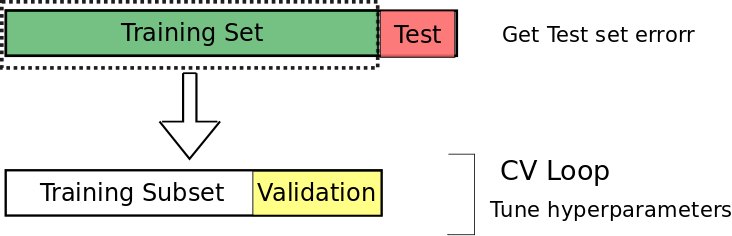

The best parameter is 49


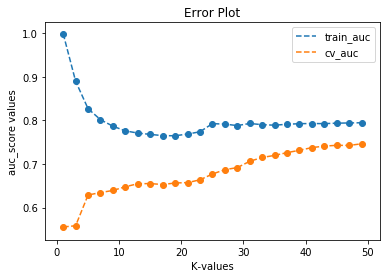

In [271]:
## finding optimal k using cross validation technique.

from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_train_bow=[]
roc_auc_cv_bow = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model  = KNeighborsClassifier(n_neighbors = i,algorithm = "brute" )
    knn_model.fit(x_train_bow,y_train_brute.ravel())
    
    y_train_score = knn_model.predict_proba(x_train_bow)[:,1]
    y_crossval_score = knn_model.predict_proba(x_crossval_bow)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_train_bow.append(roc_auc_score(y_train_brute,y_train_score))
    roc_auc_cv_bow.append(roc_auc_score(y_crossval_brute,y_crossval_score))                                                           
    
#plottong graph between auc values and k valaues for both train and test
plt.plot(k_range,roc_auc_train_bow,label = "train_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_train_bow)
plt.plot(k_range,roc_auc_cv_bow,label = "cv_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_cv_bow)
plt.xlabel("K-values")
plt.ylabel("auc_score values")
plt.title("Error Plot") 
plt.legend()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_train_bow[i]-roc_auc_cv_bow[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)    



In [272]:
#Training the model with optimal value of k .

knn_bow =KNeighborsClassifier(n_neighbors = 49, algorithm = "brute")
knn_bow.fit(X_train_bow,Y_train_brute.ravel())

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')

#### Performance Metrics for K-NN model ON BOW.

In [273]:
pred_bow = knn_bow.predict(x_test_bow)
#train test accuracy
train_acc_bow = knn_bow.score(X_train_bow,Y_train_brute.ravel())
test_acc_bow = knn_bow.score(x_test_bow,y_test_brute)

#train test ROC value
y_scores_bow_train = knn_bow.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train_brute,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_bow = auc(fpr,tpr)

y_scores_bow_test = knn_bow.predict_proba(x_test_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_bow = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_bow = precision_score(y_test_brute, pred_bow) * 100
rec_bow = recall_score(y_test_brute, pred_bow) * 100
f1_bow = f1_score(y_test_brute, pred_bow) * 100


print("\nTrain accuracy=%f%%"% (train_acc_bow*100))
print("\nTest accuracy=%e%% "% (test_acc_bow*100))
print("\nTrain ROC value=%f"% (roc_auc_train_bow))
print("\nTest ROC value=%f"% (roc_auc_test_bow))
print('\nprecision=%f%%' % (pre_bow))
print('\nrecall=%f%%' % (rec_bow))
print('\nF1-Score=%f%%' % (f1_bow))


Train accuracy=75.778571%

Test accuracy=6.956667e+01% 

Train ROC value=0.800150

Test ROC value=0.746709

precision=70.375380%

recall=68.657209%

F1-Score=69.505678%


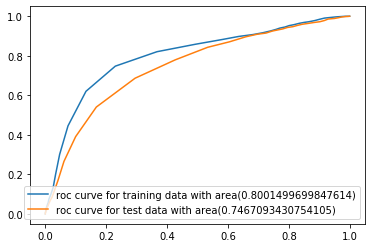

In [274]:
#PLOTTING ROC CURVE FOR TRAINING AS WELL AS TEST DATA
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_bow))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_bow))
plt.legend(loc="lower right")
plt.show()

In [275]:
#FINDING CONFUSION MATRIX:
pred_bow = knn_bow.predict(x_test_bow)
cm_bow = confusion_matrix(y_test_brute, pred_bow)
cm_bow

array([[2093,  876],
       [ 950, 2081]], dtype=int64)

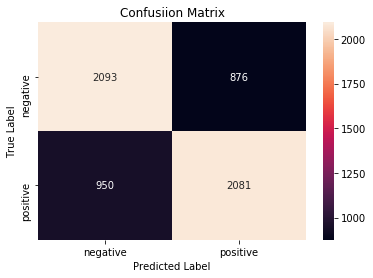

In [276]:
#NOTE: Took help from link :#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [277]:
from prettytable import PrettyTable
x = PrettyTable()

K_bow = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_bow = np.around(100 - train_acc_bow*100 , decimals = 2)
err_test_bow =  np.around(100 - test_acc_bow*100 , decimals = 2)
pre_bow= np.around(pre_bow, decimals = 2)
rec_bow = np.around(rec_bow, decimals = 2)
f1_bow = np.around(f1_bow, decimals = 2)
TPR = 2081
TNR = 2093
FPR = 950
FNR = 876


x.add_row([cv,K,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+------+-----+-----+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR  | TNR  | FPR | FNR |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+------+-----+-----+
| cross_validation |    3    |     24.22      |     30.43     |    70.38     |   68.66   |    69.51    | 2081 | 2093 | 950 | 876 |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+------+-----+-----+


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [94]:
#USING FINALISED DATA FROM ABOVE 

print(final_cleaned_data.shape)
final_cleaned_data.head()

(20000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
333930,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,1,2002-01-06,A little piece of heaven.,For years I have been trying to simulate a tru...,years trying simulate truly italian espresso c...
346095,374401,B00004CI84,A3M5O6UHXO9IBU,Gary,2,34,0,2003-05-07,Certificate: Puerile,Embarrassing comedy that comes over like a chi...,embarrassing comedy comes like child attention...
124630,135144,B001KWK1N8,A3FS8HDE2BTD5Z,"C. Boeck ""cebii""",1,1,1,2003-11-12,really the best,I buy this at our neighborhood supermarket. I...,buy neighborhood supermarket really best soymi...
189026,204997,B0000DIZ6N,AAYW1H4SMNOI,"AFP ""AFP""",4,4,1,2003-12-01,One of the best gums out there.,There's alot of good tasting gum but this is e...,alot good tasting gum easily one best extremel...


In [95]:
# dividing data into train, cross validation, and test set.
X_brute_tfidf = np.array(final_cleaned_data.loc[:,["cleaned_text"]])  #getting all cleaned review text values
Y_brute_tfidf = np.array(final_cleaned_data.loc[:,["Score"]]) #getting all scores values

#dividing 70 percent into train+cross and 30% into test
X_train_brute_tfidf,x_test_brute_tfidf,Y_train_brute_tfidf,y_test_brute_tfidf = model_selection.train_test_split(X_brute_tfidf,Y_brute_tfidf,test_size=0.3,random_state=42)

#I have seen random_state=42 used in many official examples of scikit as well as elsewhere also.So,considering random numbers= 42
#for better randomness in the data division.

#dividing above 70 percent into train and cross validation data
x_train_brute_tfidf,x_cv_brute_tfidf,y_train_brute_tfidf,y_cv_brute_tfidf = model_selection.train_test_split(X_train_brute_tfidf,Y_train_brute_tfidf,test_size=0.3,random_state=42)

print(X_train_brute_tfidf.shape , Y_train_brute_tfidf.shape)
print(x_train_brute_tfidf.shape , y_train_brute_tfidf.shape)
print(x_cv_brute_tfidf.shape , y_cv_brute_tfidf.shape)
print(x_test_brute_tfidf.shape , y_test_brute_tfidf.shape)

(14000, 1) (14000, 1)
(9800, 1) (9800, 1)
(4200, 1) (4200, 1)
(6000, 1) (6000, 1)


In [96]:
#converting train,cross validation , and test data into vectors using TF_IDF representation

X_train_brute_tfidf = pd.DataFrame(X_train_brute_tfidf,columns = ["text"])
x_train_brute_tfidf = pd.DataFrame(x_train_brute_tfidf,columns = ["text"])
x_cv_brute_tfidf = pd.DataFrame(x_cv_brute_tfidf,columns = ["text"])
x_test_brute_tfidf = pd.DataFrame(x_test_brute_tfidf,columns = ["text"])

#########################################################################
tf_idf_vect_brute = TfidfVectorizer(ngram_range=(1,3))    #considering uni, bi and trigrams
tf_idf_vect_brute.fit(x_train_brute_tfidf)



################################################################################
X_train_tfidf = tf_idf_vect_brute.transform(X_train_brute_tfidf["text"].values.astype('U'))
x_train_tfidf =  tf_idf_vect_brute.transform(x_train_brute_tfidf["text"].values.astype('U'))
x_cv_tfidf =  tf_idf_vect_brute.transform(x_cv_brute_tfidf["text"].values.astype('U'))
x_test_tfidf =  tf_idf_vect_brute.transform(x_test_brute_tfidf["text"].values.astype('U'))







##### FINDING BEST HYPERPARAMETER.

### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
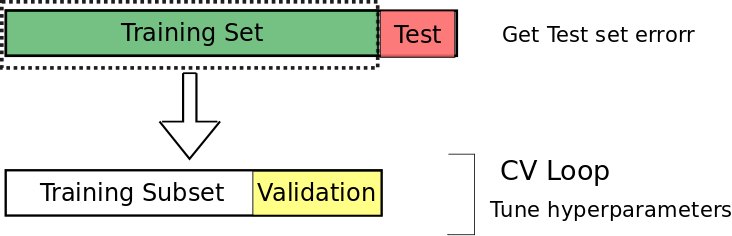

The best parameter is 3


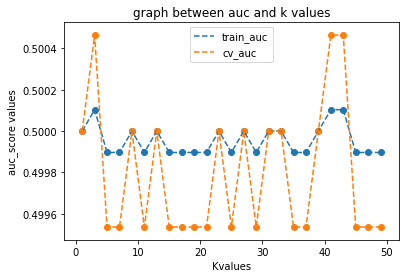

In [278]:
# finding optimal value of K.

roc_auc_train_tfidf=[]
roc_auc_cv_tfidf = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_tfidf  = KNeighborsClassifier(n_neighbors = i,algorithm = "brute" )
    knn_model_tfidf.fit(x_train_tfidf,y_train_brute_tfidf.ravel())
    
    y_train_score = knn_model_tfidf.predict_proba(x_train_tfidf)[:,1]
    y_crossval_score = knn_model_tfidf.predict_proba(x_cv_tfidf)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_train_tfidf.append(roc_auc_score(y_train_brute_tfidf,y_train_score))
    roc_auc_cv_tfidf.append(roc_auc_score(y_cv_brute_tfidf,y_crossval_score))                                                           
    
    #plottong graph between auc values and k valaues for both train and test
plt.plot(k_range,roc_auc_train_tfidf,label = "train_auc",linestyle ="dashed")
plt.scatter(k_range,roc_auc_train_tfidf)
plt.plot(k_range,roc_auc_cv_tfidf,label = "cv_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_cv_tfidf)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_train_tfidf[i]-roc_auc_cv_tfidf[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)    


                                                              

In [279]:
knn_tfidf_brute = neighbors.KNeighborsClassifier(n_neighbors = 3, algorithm = "brute")
knn_tfidf_brute.fit(X_train_tfidf,Y_train_brute_tfidf.ravel())

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### Performance Metrics 

In [280]:
pred_tfidf = knn_tfidf_brute.predict(x_test_tfidf)
#train test accuracy
train_acc_tfidf = knn_tfidf_brute.score(X_train_tfidf,Y_train_brute.ravel())
test_acc_tfidf = knn_tfidf_brute.score(x_test_tfidf,y_test_brute)

#train test ROC value
y_scores_tfidf_train = knn_tfidf_brute.predict_proba(x_train_tfidf)
fpr,tpr,thresholds = roc_curve(y_train_brute,y_scores_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_tfidf = auc(fpr,tpr)

y_scores_tfidf_test = knn_tfidf_brute.predict_proba(x_test_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute,y_scores_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_tfidf = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_tfidf = precision_score(y_test_brute, pred_tfidf) * 100
rec_tfidf = recall_score(y_test_brute, pred_tfidf) * 100
f1_tfidf = f1_score(y_test_brute, pred_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf*100))
print("\nTrain ROC value=%f"% (roc_auc_train_tfidf))
print("\nTest ROC value=%f"% (roc_auc_test_tfidf))
print('\nprecision=%f%%' % (pre_tfidf))
print('\nrecall=%f%%' % (rec_tfidf))
print('\nF1-Score=%f%%' % (f1_tfidf))


Train accuracy=49.800000%

Test accuracy=5.050000e+01% 

Train ROC value=0.500103

Test ROC value=0.499838

precision=50.508588%

recall=99.934015%

F1-Score=67.102348%


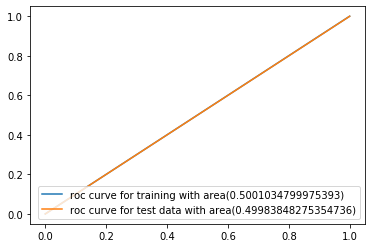

In [281]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_tfidf))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_tfidf))
plt.legend(loc="lower right")
plt.show()

In [282]:
pred_brute_tfidf = knn_tfidf_brute.predict(x_test_tfidf)
cm_brute_tfidf = confusion_matrix(y_test_brute_tfidf, pred_brute_tfidf)
cm_brute_tfidf

array([[   1, 2968],
       [   2, 3029]], dtype=int64)

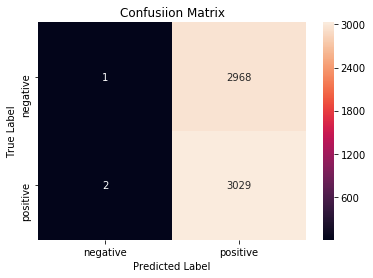

In [283]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_brute_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [284]:
from prettytable import PrettyTable
x = PrettyTable()

K_tfidf = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_tfidf = np.around(100 - train_acc_tfidf*100 , decimals = 2)
err_test_tfidf =  np.around(100 - test_acc_tfidf*100 , decimals = 2)
pre_tfidf = np.around(pre_tfidf, decimals = 2)
rec_tfidf = np.around(rec_tfidf, decimals = 2)
f1_tfidf = np.around(f1_tfidf, decimals = 2)
TPR = 3029
TNR = 1
FPR = 2
FNR = 2968


x.add_row([cv,K_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR  | TNR | FPR | FNR  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
| cross_validation |    3    |      50.2      |      49.5     |    50.51     |   99.93   |     67.1    | 3029 |  1  |  2  | 2968 |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+


#### OBSERVATION:
 1. The TNR value is very low while FNR value is high, which implies the TFIDF model is DUMB.

## WORD2VEC

In [105]:
#converting all the dataframe into list.

X_train_brute_w2v = X_train_brute_tfidf["text"].tolist() 
x_train_brute_w2v = x_train_brute_tfidf["text"].tolist()
x_cv_brute_w2v = x_cv_brute_tfidf["text"].tolist()
x_test_brute_w2v = x_test_brute_tfidf["text"].tolist()


In [106]:
#storing  all the datasets into one list
data_for_brute_w2v = []
data_for_brute_w2v.append(X_train_brute_w2v)
data_for_brute_w2v.append(x_train_brute_w2v)
data_for_brute_w2v.append(x_cv_brute_w2v)
data_for_brute_w2v.append(x_test_brute_w2v)


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [107]:
# Train your own Word2Vec model using your own text corpus

#appending the text for train test crossval in one list.
#note: 
    # index 0 implies x_1 data
    #index 1 implies x_train data
    # index 2 implies x_crossval data
    #index 3 implies x_test data
    

count = 0
list_of_sentance_for_w2v_brute = []
for i in data_for_brute_w2v:
    locals()['list_of_sentance_{}'.format(count)] = []
    for sentance in i:
        locals()['list_of_sentance_{}'.format(count)].append(sentance.split())
        
    count +=1
    
list_of_sentance_for_w2v_brute.append(list_of_sentance_0) 
list_of_sentance_for_w2v_brute.append(list_of_sentance_1) 
list_of_sentance_for_w2v_brute.append(list_of_sentance_2) 
list_of_sentance_for_w2v_brute.append(list_of_sentance_3)

            

In [108]:
#Training w2v model / converting texts into vectors.

counts = 0
for i in list_of_sentance_for_w2v_brute:
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        locals()['w2v_model_{}'.format(counts)]=Word2Vec(i,min_count=5,size=50, workers=4)
        locals()['w2v_words_{}'.format(counts)] = list(locals()['w2v_model_{}'.format(counts)].wv.vocab)
    
    
    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    counts+=1            
            
print(w2v_model_0)    # x_1 data
print(w2v_model_1)  #x_train data
print(w2v_model_2)    #x_crossval data
print(w2v_model_3)  #x_test data
print(w2v_words_1[6])

Word2Vec(vocab=7642, size=50, alpha=0.025)
Word2Vec(vocab=6351, size=50, alpha=0.025)
Word2Vec(vocab=3782, size=50, alpha=0.025)
Word2Vec(vocab=4794, size=50, alpha=0.025)
larger


#### Average w2v 

In [109]:
# average Word2Vec
# compute average word2vec for each review.
# the avg-w2v for each sentence/review is stored in this list= []; # the avg-w2v for each sentence/review is stored in this list = []; # the avg-w2v for each sentence/review is stored in this list


k=0
vectors_for_avg_w2v_brute = []
for i in list_of_sentance_for_w2v_brute:
    locals()['data_{}'.format(k)] = []
    for sent in tqdm(i):
       # for each review/sentence
        sent_vec= np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in locals()['w2v_words_{}'.format(k)]:
                vec = locals()['w2v_model_{}'.format(k)].wv[word]
                sent_vec+= vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        locals()['data_{}'.format(k)].append(sent_vec)
    vectors_for_avg_w2v_brute.append(locals()['data_{}'.format(k)]) 
    k+=1
            
           
##NOTE: vectors_for_avg_w2v list contains vectors representation of x_1, x_train , x_crossval , x_test.            
         
     

            
            

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:09<00:00, 600.81it/s]


In [110]:
# vectors_for_avg_w2v contains w2v vector representation of x_1, x_train,x_crossval,x_test.

### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
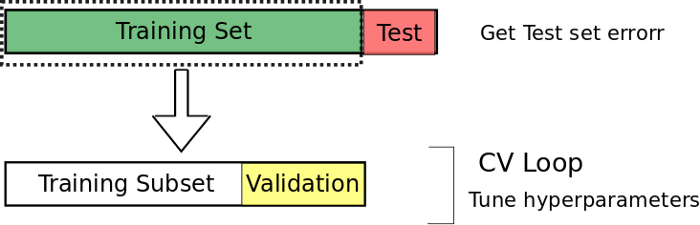

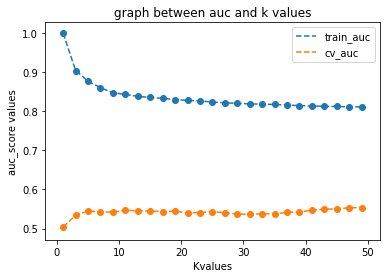

The best parameter is 49


In [287]:
# finding optimal value of K.
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_train_avg_w2v=[]
roc_auc_cv_avg_w2v = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_avg_w2v  = KNeighborsClassifier(n_neighbors = i,algorithm = "brute" )
    knn_model_avg_w2v.fit(vectors_for_avg_w2v_brute[1],y_train_brute.ravel())
    
    y_train_score = knn_model_avg_w2v.predict_proba(vectors_for_avg_w2v_brute[1])[:,1]
    y_crossval_score = knn_model_avg_w2v.predict_proba(vectors_for_avg_w2v_brute[2])[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_train_avg_w2v.append(roc_auc_score(y_train_brute,y_train_score))
    roc_auc_cv_avg_w2v.append(roc_auc_score(y_crossval_brute,y_crossval_score))                                                           
    
    #plottong graph between auc values and k valaues for both train and test
plt.plot(k_range,roc_auc_train_avg_w2v,label = "train_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_train_avg_w2v)
plt.plot(k_range,roc_auc_cv_avg_w2v,label = "cv_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_cv_avg_w2v)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()
#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_train_avg_w2v[i]-roc_auc_cv_avg_w2v[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)       
                                                                 

In [288]:
knn_brute_w2v = KNeighborsClassifier(n_neighbors = 49 , algorithm = "brute")
knn_brute_w2v.fit(vectors_for_avg_w2v_brute[0],Y_train_brute_tfidf.ravel())

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')

### Performance Metrices

In [289]:
pred_avg_w2v = knn_brute_w2v.predict(vectors_for_avg_w2v_brute[3])
#train test accuracy
train_acc_avg_w2v = knn_brute_w2v.score(vectors_for_avg_w2v_brute[0],Y_train_brute.ravel())
test_acc_avg_w2v = knn_brute_w2v.score(vectors_for_avg_w2v_brute[3],y_test_brute)

#train test ROC value
y_scores_avg_w2v_train = knn_brute_w2v.predict_proba(vectors_for_avg_w2v_brute[1])
fpr,tpr,thresholds = roc_curve(y_train_brute,y_scores_avg_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_avg_w2v = auc(fpr,tpr)

y_scores_avg_w2v_test = knn_brute_w2v.predict_proba(vectors_for_avg_w2v_brute[3])
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute,y_scores_avg_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_avg_w2v = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_avg_w2v = precision_score(y_test_brute, pred_avg_w2v) * 100
rec_avg_w2v = recall_score(y_test_brute, pred_avg_w2v) * 100
f1_avg_w2v = f1_score(y_test_brute, pred_avg_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_avg_w2v*100))
print("\nTest accuracy=%e%% "% (test_acc_avg_w2v*100))
print("\nTrain ROC value=%f"% (roc_auc_train_avg_w2v))
print("\nTest ROC value=%f"% (roc_auc_test_avg_w2v))
print('\nprecision=%f%%' % (pre_avg_w2v))
print('\nrecall=%f%%' % (rec_avg_w2v))
print('\nF1-Score=%f%%' % (f1_avg_w2v))


Train accuracy=78.200000%

Test accuracy=5.595000e+01% 

Train ROC value=0.718539

Test ROC value=0.603492

precision=54.389140%

recall=79.313758%

F1-Score=64.528251%


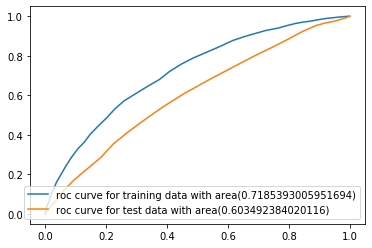

In [290]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_avg_w2v))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_avg_w2v))
plt.legend(loc="lower right")
plt.show()

In [291]:
cm_w2v = confusion_matrix(y_test_brute_tfidf, pred_avg_w2v)
cm_w2v

array([[ 953, 2016],
       [ 627, 2404]], dtype=int64)

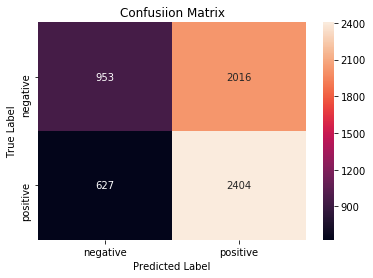

In [292]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [293]:
from prettytable import PrettyTable
x = PrettyTable()

K_avg_w2v = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_avg_w2v = np.around(100 - train_acc_avg_w2v*100 , decimals = 2)
err_test_avg_w2v =  np.around(100 - test_acc_avg_w2v*100 , decimals = 2)
pre_avg_w2v = np.around(pre_avg_w2v, decimals = 2)
rec_avg_w2v = np.around(rec_avg_w2v, decimals = 2)
f1_avg_w2v = np.around(f1_avg_w2v, decimals = 2)
TPR = 2404
TNR = 953
FPR = 627
FNR = 2016


x.add_row([cv,K_avg_w2v,err_train_avg_w2v,err_test_avg_w2v,pre_avg_w2v,rec_avg_w2v,f1_avg_w2v,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR  | TNR | FPR | FNR  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
| cross_validation |    49   |      21.8      |     44.05     |    54.39     |   79.31   |    64.53    | 2404 | 953 | 627 | 2016 |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

#### <font color = "red">  CROSS VALIDATION

In [126]:
# CONVERTING TEST DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_brute_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [127]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train_brute_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [21:18<00:00, 10.95it/s]


In [128]:
# CONVERTING TEST DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_test_brute_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [129]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_test_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test_brute_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [05:35<00:00, 17.89it/s]


In [130]:
# CONVERTING TRAIN DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train_brute_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_train_brute_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 9800/9800 [12:08<00:00, 13.45it/s]


In [132]:
# CONVERTING CROSS VALIDATION DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_cv_brute_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [133]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_cv_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_cv_brute_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_cv_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4200/4200 [02:56<00:00, 23.78it/s]


### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
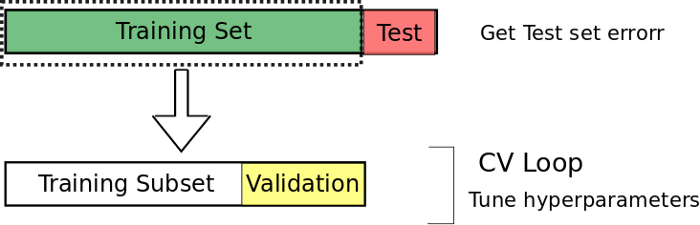

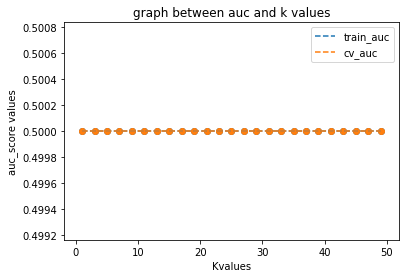

The best parameter is 1


In [294]:
# finding optimal value of K.
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_train_tfidf_w2v=[]
roc_auc_cv_tfidf_w2v = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_tfidf_w2v  = KNeighborsClassifier(n_neighbors = i,algorithm = "brute" )
    knn_model_tfidf_w2v.fit(x_train_tfidf_w2v,y_train_brute_tfidf.ravel())
    
    y_train_score = knn_model_tfidf_w2v.predict_proba(x_train_tfidf_w2v)[:,1]
    y_cv_score = knn_model_tfidf_w2v.predict_proba(x_cv_tfidf_w2v)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_train_tfidf_w2v.append(roc_auc_score(y_train_brute_tfidf,y_train_score))
    roc_auc_cv_tfidf_w2v.append(roc_auc_score(y_cv_brute_tfidf,y_cv_score))                                                           
    
    #plottong graph between auc values and k valaues for both train and test
plt.plot(k_range,roc_auc_train_tfidf_w2v,label = "train_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_train_tfidf_w2v)
plt.plot(k_range,roc_auc_cv_tfidf_w2v,label = "cv_auc", linestyle = "dashed")
plt.scatter(k_range,roc_auc_cv_tfidf_w2v)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_train_tfidf_w2v[i]-roc_auc_cv_tfidf_w2v[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)
                                                          

In [295]:
knn_tfidf_w2v_brute = KNeighborsClassifier(n_neighbors = 49 , algorithm = "brute")
knn_tfidf_w2v_brute.fit(X_train_tfidf_w2v,Y_train_brute_tfidf.ravel())

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')

### performance metrices

In [296]:
pred_tfidf_w2v = knn_tfidf_w2v_brute.predict(x_test_tfidf_w2v)
#train test accuracy
train_acc_tfidf_w2v = knn_tfidf_w2v_brute.score(X_train_tfidf_w2v,Y_train_brute.ravel())
test_acc_tfidf_w2v = knn_tfidf_w2v_brute.score(x_test_tfidf_w2v,y_test_brute)

#train test ROC value
y_scores_tfidf_w2v_train = knn_tfidf_w2v_brute.predict_proba(x_train_tfidf_w2v)
fpr,tpr,thresholds = roc_curve(y_train_brute,y_scores_tfidf_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_tfidf_w2v = auc(fpr,tpr)

y_scores_tfidf_w2v_test = knn_tfidf_w2v_brute.predict_proba(x_test_tfidf_w2v)
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute,y_scores_tfidf_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_tfidf_w2v = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_tfidf_w2v = precision_score(y_test_brute, pred_tfidf_w2v) * 100
rec_tfidf_w2v = recall_score(y_test_brute, pred_tfidf_w2v) * 100
f1_tfidf_w2v = f1_score(y_test_brute, pred_tfidf_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf_w2v*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf_w2v*100))
print("\nTrain ROC value=%f"% (roc_auc_train_tfidf_w2v))
print("\nTest ROC value=%f"% (roc_auc_test_tfidf_w2v))
print('\nprecision=%f%%' % (pre_tfidf_w2v))
print('\nrecall=%f%%' % (rec_tfidf_w2v))
print('\nF1-Score=%f%%' % (f1_tfidf_w2v))


Train accuracy=50.221429%

Test accuracy=4.948333e+01% 

Train ROC value=0.500000

Test ROC value=0.500000

precision=0.000000%

recall=0.000000%

F1-Score=0.000000%


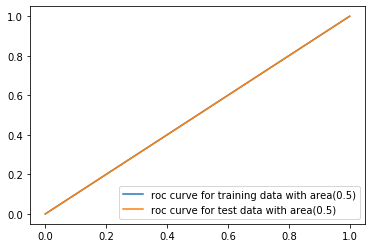

In [297]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_tfidf_w2v))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_tfidf_w2v))
plt.legend(loc="lower right")
plt.show()

In [298]:
cm_tfidf_w2v = confusion_matrix(y_test_brute_tfidf, pred_tfidf_w2v)
cm_tfidf_w2v

array([[2969,    0],
       [3031,    0]], dtype=int64)

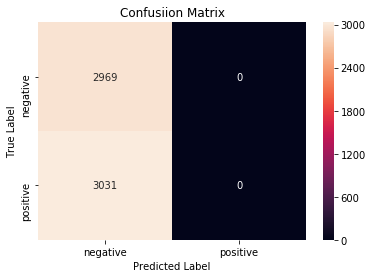

In [299]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tfidf_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [300]:
from prettytable import PrettyTable
x = PrettyTable()

K_tfidf_w2v = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_tfidf_w2v = np.around(100 - train_acc_tfidf_w2v*100 , decimals = 2)
err_test_tfidf_w2v =  np.around(100 - test_acc_tfidf_w2v*100 , decimals = 2)
pre_tfidf_w2v = np.around(pre_tfidf_w2v, decimals = 2)
rec_tfidf_w2v = np.around(rec_tfidf_w2v, decimals = 2)
f1_tfidf_w2v = np.around(f1_tfidf_w2v, decimals = 2)
TPR = 0
TNR = 2969
FPR = 3031
FNR = 0


x.add_row([cv,K_tfidf_w2v,err_train_tfidf_w2v,err_test_tfidf_w2v,pre_tfidf_w2v,rec_tfidf_w2v,f1_tfidf_w2v,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR | TNR  | FPR  | FNR |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
| cross_validation |    1    |     49.78      |     50.52     |     0.0      |    0.0    |     0.0     |  0  | 2969 | 3031 |  0  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+


#### OBSERVATION:
1. TPR value for given model is 0. Hence,W2V tfidf model is dumb.

### FINAL TABLE FOR BRUTE FORCE.

In [301]:
from prettytable import PrettyTable
x = PrettyTable()


model1 = "BOW"
model2 ="TFIDF"
model3 = "AVG_W2V"
model4 = "TFIDF_W2V"
x.field_names = ["model","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]
x.add_row([model1,K_bow,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow])
x.add_row([model2,K_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf])
x.add_row([model3,K_avg_w2v,err_train_avg_w2v,err_test_avg_w2v,pre_avg_w2v,rec_avg_w2v,f1_avg_w2v])
x.add_row([model4,K_tfidf_w2v,err_train_tfidf_w2v,err_test_tfidf_w2v,pre_tfidf_w2v,rec_tfidf_w2v,f1_tfidf_w2v])


print(x)

+-----------+---------+----------------+---------------+--------------+-----------+-------------+
|   model   | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+-----------+---------+----------------+---------------+--------------+-----------+-------------+
|    BOW    |    49   |     24.22      |     30.43     |    70.38     |   68.66   |    69.51    |
|   TFIDF   |    3    |      50.2      |      49.5     |    50.51     |   99.93   |     67.1    |
|  AVG_W2V  |    49   |      21.8      |     44.05     |    54.39     |   79.31   |    64.53    |
| TFIDF_W2V |    1    |     49.78      |     50.52     |     0.0      |    0.0    |     0.0     |
+-----------+---------+----------------+---------------+--------------+-----------+-------------+


## CONCLUSION :

1. The K-nearest neighbours for BOW, TFIDF, avg_w2v, tfidf_w2v are 49,3,49, and 1 respectively.<br>
2. The train and test error for TFIDF and TFDIF_w2v are much higher as compared to BOW and avg_w2v.<br>
3. True positive rate for both TFIDF and TFIDF_W2V based model  is zero i.e (number of positive reviews are predicted to be positive by our model) while True negative rate is 100. So, we can conclude that TFIDF based model is DUMB.
4. For classification, BOW and BOW-w2v model can be used,but even for these models performance metrics are not so satisfactorily good.<br>

If possible, We should try another model for more confidence on classification


## [5.2] Applying KNN kd-tree

## NOTE:
###### <font color = "red"> CONSIDERING VERY LESS DATA POINTS DUE TO LARGE TIME COMPLEXITY FOR BOW representation.(only 2000)

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [215]:
#Conversion of sparse bow representation into dense representation.

X_train_kd_bow = X_train_bow[:1400].toarray()       
x_train_kd_bow = x_train_bow[:980].toarray()
x_crossval_kd_bow =  x_crossval_bow[:420].toarray()
x_test_kd_bow = x_test_bow[:600].toarray() 

Y_train_kd_bow = Y_train_brute[:1400]
y_train_kd_bow = y_train_brute[:980]
y_crossval_kd_bow =  y_crossval_brute[:420]
y_test_kd_bow = y_test_brute[:600]

           
print(y_train_kd_bow.shape)

(980, 1)


### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
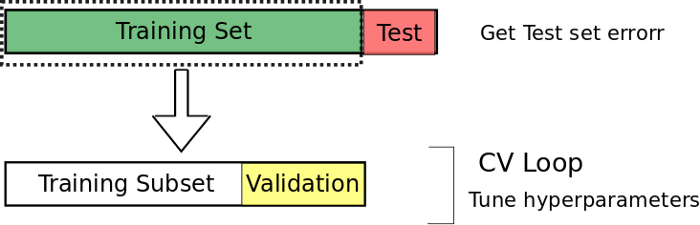

In [305]:
# finding optimal value of K.
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_kd_train_bow=[]
roc_auc_kd_cv_bow = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_bow_kd  = KNeighborsClassifier(n_neighbors = i,algorithm = "kd_tree" )
    knn_model_bow_kd.fit(x_train_kd_bow,y_train_kd_bow.ravel())
    
    y_train_score = knn_model_bow_kd.predict_proba(x_train_kd_bow)[:,1]
    y_crossval_score = knn_model_bow_kd.predict_proba(x_crossval_kd_bow)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_kd_train_bow.append(roc_auc_score(y_train_kd_bow,y_train_score))
    roc_auc_kd_cv_bow.append(roc_auc_score(y_crossval_kd_bow,y_crossval_score))                                                           
    



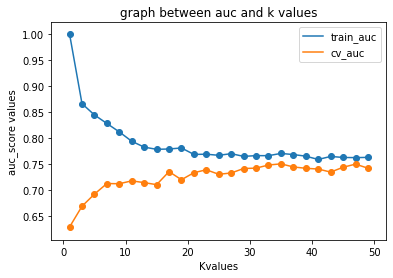

The best parameter is 47


In [306]:
plt.plot(k_range,roc_auc_kd_train_bow,label = "train_auc")
plt.scatter(k_range,roc_auc_kd_train_bow)
plt.plot(k_range,roc_auc_kd_cv_bow,label = "cv_auc")
plt.scatter(k_range,roc_auc_kd_cv_bow)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_kd_train_bow[i]-roc_auc_kd_cv_bow[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)
                                                          

In [307]:
#Training the model with optimal value of k .
knn_kd_bow = neighbors.KNeighborsClassifier(n_neighbors = 47 , algorithm = "kd_tree")
knn_kd_bow.fit(X_train_kd_bow,Y_train_kd_bow.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')

### performance metrices

In [308]:
pred_kd_bow = knn_kd_bow.predict(x_test_kd_bow)
#train test accuracy
train_acc_kd_bow = knn_kd_bow.score(X_train_kd_bow,Y_train_kd_bow.ravel())
test_acc_kd_bow = knn_kd_bow.score(x_test_kd_bow,y_test_kd_bow)

#train test ROC value
y_scores_bow_train = knn_kd_bow.predict_proba(x_train_kd_bow)
fpr,tpr,thresholds = roc_curve(y_train_kd_bow,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_kd_bow = auc(fpr,tpr)

y_scores_bow_test = knn_kd_bow.predict_proba(x_test_kd_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test_kd_bow,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_kd_bow = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_kd_bow = precision_score(y_test_kd_bow, pred_kd_bow) * 100
rec_kd_bow = recall_score(y_test_kd_bow, pred_kd_bow) * 100
f1_kd_bow = f1_score(y_test_kd_bow, pred_kd_bow) * 100


print("\nTrain accuracy=%f%%"% (train_acc_kd_bow*100))
print("\nTest accuracy=%e%% "% (test_acc_kd_bow*100))
print("\nTrain ROC value=%f"% (roc_auc_train_kd_bow))
print("\nTest ROC value=%f"% (roc_auc_test_kd_bow))
print('\nprecision=%f%%' % (pre_kd_bow))
print('\nrecall=%f%%' % (rec_kd_bow))
print('\nF1-Score=%f%%' % (f1_kd_bow))


Train accuracy=69.071429%

Test accuracy=6.466667e+01% 

Train ROC value=0.750347

Test ROC value=0.756257

precision=78.740157%

recall=35.087719%

F1-Score=48.543689%


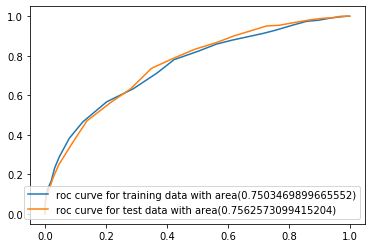

In [309]:
#PLOTTING ROC CURVE FOR TRAINING AS WELL AS TEST DATA
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_kd_bow))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_kd_bow))
plt.legend(loc="lower right")
plt.show()

In [310]:
#FINDING CONFUSION MATRIX:
pred_kd_bow = knn_kd_bow.predict(x_test_kd_bow)
cm_kd_bow = confusion_matrix(y_test_kd_bow, pred_kd_bow)
cm_kd_bow

array([[288,  27],
       [185, 100]], dtype=int64)

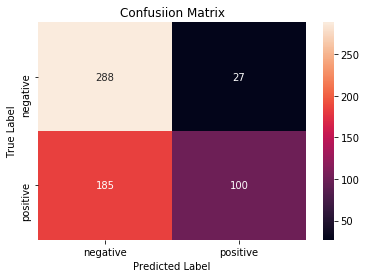

In [311]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_kd_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [312]:
from prettytable import PrettyTable
x = PrettyTable()

K_kd_bow = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_kd_bow = np.around(100 - train_acc_kd_bow*100 , decimals = 2)
err_test_kd_bow =  np.around(100 - test_acc_kd_bow*100 , decimals = 2)
pre_kd_bow= np.around(pre_kd_bow, decimals = 2)
rec_kd_bow = np.around(rec_kd_bow, decimals = 2)
f1_kd_bow = np.around(f1_kd_bow, decimals = 2)
TPR = 100
TNR = 288
FPR = 185
FNR = 27


x.add_row([cv,K_kd_bow,err_train_kd_bow,err_test_kd_bow,pre_kd_bow,rec_kd_bow,f1_kd_bow,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+-----+-----+-----+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR | TNR | FPR | FNR |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+-----+-----+-----+
| cross_validation |    47   |     30.93      |     35.33     |    78.74     |   35.09   |    48.54    | 100 | 288 | 185 |  27 |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+-----+-----+-----+


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [228]:
## CONSIDERING 20000 data points for further model.

X_train_kd_tfidf = X_train_tfidf.toarray() 
x_train_kd_tfidf = x_train_tfidf.toarray()
x_cv_kd_tfidf =  x_cv_tfidf.toarray()
x_test_kd_tfidf = x_test_tfidf.toarray() 
#x_1_kd_tfidf = x_1_kd_tfidf[:700]
#x_test_kd_tfidf = x_test_kd_tfidf[:300]
#x_train_kd_tfidf = x_train_kd_tfidf[:490]
#x_crossval_kd_tfidf = x_crossval_kd_tfidf[:210]
    
Y_train_kd_tfidf = Y_train_brute_tfidf                             
y_test_kd_tfidf = y_test_brute_tfidf
      
y_train_kd_tfidf = y_train_brute_tfidf

y_cv_kd_tfidf = y_cv_brute_tfidf


### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
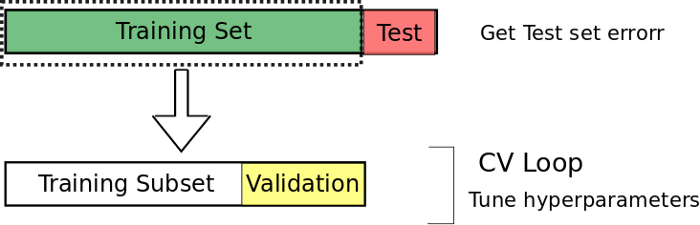

In [313]:
# finding optimal value of K.

roc_auc_kd_train_tfidf=[]
roc_auc_kd_cv_tfidf = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_kd_tfidf  = KNeighborsClassifier(n_neighbors = i,algorithm = "kd_tree" )
    knn_model_kd_tfidf.fit(x_train_kd_tfidf,y_train_brute_tfidf.ravel())
    
    y_train_score = knn_model_kd_tfidf.predict_proba(x_train_kd_tfidf)[:,1]
    y_cv_score = knn_model_kd_tfidf.predict_proba(x_cv_kd_tfidf)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_kd_train_tfidf.append(roc_auc_score(y_train_brute,y_train_score))
    roc_auc_kd_cv_tfidf.append(roc_auc_score(y_cv_brute_tfidf,y_cv_score))                                                           
    
  
                                                          

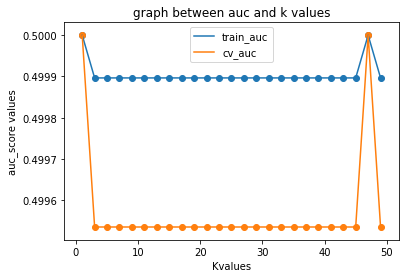

The best parameter is 1


In [314]:
plt.plot(k_range,roc_auc_kd_train_tfidf,label = "train_auc")
plt.scatter(k_range,roc_auc_kd_train_tfidf)
plt.plot(k_range,roc_auc_kd_cv_tfidf,label = "cv_auc")
plt.scatter(k_range,roc_auc_kd_cv_tfidf)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_kd_train_tfidf[i]-roc_auc_kd_cv_tfidf[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)
                                                          

In [315]:
#Training the model with optimal value of k .
knn_kd_tfidf = neighbors.KNeighborsClassifier(n_neighbors = 1 , algorithm = "kd_tree")
knn_kd_tfidf.fit(x_train_kd_tfidf,y_train_brute.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### perfromance metrices

In [316]:
pred_kd_tfidf = knn_kd_tfidf.predict(x_test_kd_tfidf)
#train test accuracy
train_acc_kd_tfidf = knn_kd_tfidf.score(X_train_kd_tfidf,Y_train_kd_tfidf.ravel())
test_acc_kd_tfidf = knn_kd_tfidf.score(x_test_kd_tfidf,y_test_kd_tfidf)

#train test ROC value
y_scores_tfidf_train = knn_kd_tfidf.predict_proba(x_train_kd_tfidf)
fpr,tpr,thresholds = roc_curve(y_train_kd_tfidf,y_scores_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_kd_tfidf = auc(fpr,tpr)

y_scores_tfidf_test = knn_kd_tfidf.predict_proba(x_test_kd_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test_kd_tfidf,y_scores_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_kd_tfidf = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_kd_tfidf = precision_score(y_test_kd_tfidf, pred_kd_tfidf) * 100
rec_kd_tfidf = recall_score(y_test_kd_tfidf, pred_kd_tfidf) * 100
f1_kd_tfidf = f1_score(y_test_kd_tfidf, pred_kd_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_kd_tfidf*100))
print("\nTest accuracy=%e%% "% (test_acc_kd_tfidf*100))
print("\nTrain ROC value=%f"% (roc_auc_train_kd_tfidf))
print("\nTest ROC value=%f"% (roc_auc_test_kd_tfidf))
print('\nprecision=%f%%' % (pre_kd_tfidf))
print('\nrecall=%f%%' % (rec_kd_tfidf))
print('\nF1-Score=%f%%' % (f1_kd_tfidf))


Train accuracy=50.221429%

Test accuracy=4.948333e+01% 

Train ROC value=0.500000

Test ROC value=0.500000

precision=0.000000%

recall=0.000000%

F1-Score=0.000000%


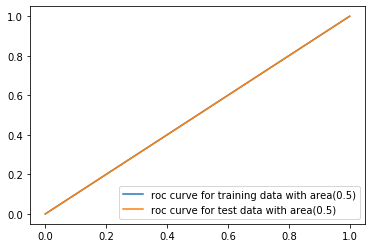

In [317]:
#PLOTTING ROC CURVE FOR TRAINING AS WELL AS TEST DATA
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_kd_tfidf))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_kd_tfidf))
plt.legend(loc="lower right")
plt.show()

In [318]:
#FINDING CONFUSION MATRIX:

cm_kd_tfidf = confusion_matrix(y_test_kd_tfidf, pred_kd_tfidf)
cm_kd_tfidf

array([[2969,    0],
       [3031,    0]], dtype=int64)

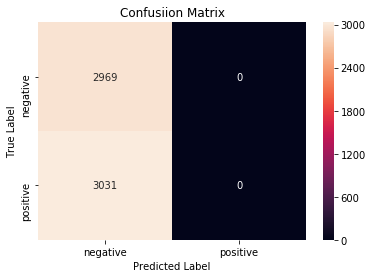

In [319]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_kd_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [320]:
from prettytable import PrettyTable
x = PrettyTable()

K_kd_tfidf = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_kd_tfidf = np.around(100 - train_acc_kd_tfidf*100 , decimals = 2)
err_test_kd_tfidf =  np.around(100 - test_acc_kd_tfidf*100 , decimals = 2)
pre_kd_tfidf= np.around(pre_kd_tfidf, decimals = 2)
rec_kd_tfidf = np.around(rec_kd_tfidf, decimals = 2)
f1_kd_tfidf = np.around(f1_kd_tfidf, decimals = 2)
TPR = 0
TNR = 2969
FPR = 3031
FNR =0


x.add_row([cv,K_kd_tfidf,err_train_kd_tfidf,err_test_kd_tfidf,pre_kd_tfidf,rec_kd_tfidf,f1_kd_tfidf,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR | TNR  | FPR  | FNR |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
| cross_validation |    1    |     49.78      |     50.52     |     0.0      |    0.0    |     0.0     |  0  | 2969 | 3031 |  0  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+


#### OBSERVATION:
The TNR value is 0. Hence, the model is dumb.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
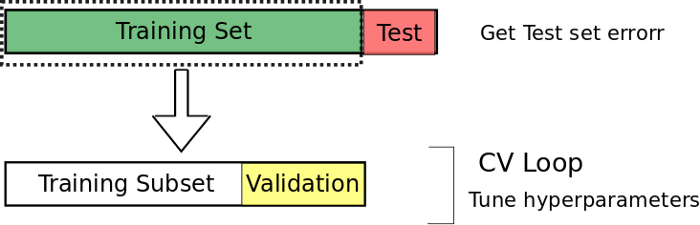

In [321]:
# finding optimal value of K.
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_train_avg_w2v_kd=[]
roc_auc_cv_avg_w2v_kd = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_avg_w2v_kd  = KNeighborsClassifier(n_neighbors = i,algorithm = "kd_tree" )
    knn_model_avg_w2v_kd.fit(vectors_for_avg_w2v_brute[1],y_train_brute_tfidf.ravel())
    
    y_train_score = knn_model_avg_w2v_kd.predict_proba(vectors_for_avg_w2v_brute[1])[:,1]
    y_cv_score = knn_model_avg_w2v_kd.predict_proba(vectors_for_avg_w2v_brute[2])[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_train_avg_w2v_kd.append(roc_auc_score(y_train_brute_tfidf,y_train_score))
    roc_auc_cv_avg_w2v_kd.append(roc_auc_score(y_cv_brute_tfidf,y_cv_score))                                                           
    
                           

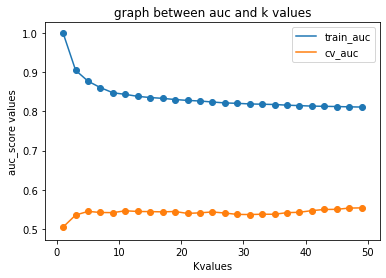

The best parameter is 49


In [322]:
plt.plot(k_range,roc_auc_train_avg_w2v_kd,label = "train_auc")
plt.scatter(k_range,roc_auc_train_avg_w2v_kd)
plt.plot(k_range,roc_auc_cv_avg_w2v_kd,label = "cv_auc")
plt.scatter(k_range,roc_auc_cv_avg_w2v_kd)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_train_avg_w2v_kd[i]-roc_auc_cv_avg_w2v_kd[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)

In [323]:
knn_kd_avg_w2v = neighbors.KNeighborsClassifier(n_neighbors = 49, algorithm = "kd_tree")
knn_kd_avg_w2v.fit(vectors_for_avg_w2v_brute[0],Y_train_brute_tfidf.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')

### performance metrices

In [324]:

pred_kd_avg_w2v = knn_kd_avg_w2v.predict(vectors_for_avg_w2v_brute[3])
#train test accuracy
train_acc_kd_avg_w2v = knn_kd_avg_w2v.score(vectors_for_avg_w2v_brute[0],Y_train_brute_tfidf.ravel())
test_acc_kd_avg_w2v = knn_kd_avg_w2v.score(vectors_for_avg_w2v_brute[3],y_test_brute_tfidf)

#train test ROC value
y_scores_avg_w2v_train = knn_kd_avg_w2v.predict_proba(vectors_for_avg_w2v_brute[1])
fpr,tpr,thresholds = roc_curve(y_train_brute_tfidf,y_scores_avg_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_kd_avg_w2v = auc(fpr,tpr)

y_scores_avg_w2v_test = knn_kd_avg_w2v.predict_proba(vectors_for_avg_w2v_brute[3])
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute_tfidf,y_scores_avg_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_kd_avg_w2v = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_kd_avg_w2v = precision_score(y_test_brute_tfidf, pred_kd_avg_w2v) * 100
rec_kd_avg_w2v = recall_score(y_test_brute_tfidf, pred_kd_avg_w2v) * 100
f1_kd_avg_w2v = f1_score(y_test_brute_tfidf, pred_kd_avg_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_kd_avg_w2v*100))
print("\nTest accuracy=%e%% "% (test_acc_kd_avg_w2v*100))
print("\nTrain ROC value=%f"% (roc_auc_train_kd_avg_w2v))
print("\nTest ROC value=%f"% (roc_auc_test_kd_avg_w2v))
print('\nprecision=%f%%' % (pre_kd_avg_w2v))
print('\nrecall=%f%%' % (rec_kd_avg_w2v))
print('\nF1-Score=%f%%' % (f1_kd_avg_w2v))


Train accuracy=78.200000%

Test accuracy=5.595000e+01% 

Train ROC value=0.718539

Test ROC value=0.603492

precision=54.389140%

recall=79.313758%

F1-Score=64.528251%


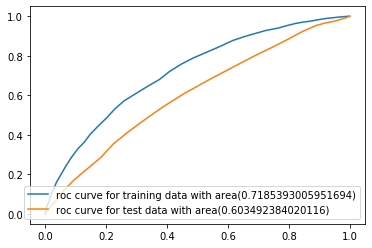

In [325]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_train_kd_avg_w2v))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_kd_avg_w2v))
plt.legend(loc="lower right")
plt.show()

In [326]:
pred_kd_avg_w2v = knn_kd_avg_w2v.predict(vectors_for_avg_w2v_brute[3])
cm_kd_avg_w2v = confusion_matrix(y_test_brute_tfidf, pred_kd_avg_w2v)
cm_kd_avg_w2v

array([[ 953, 2016],
       [ 627, 2404]], dtype=int64)

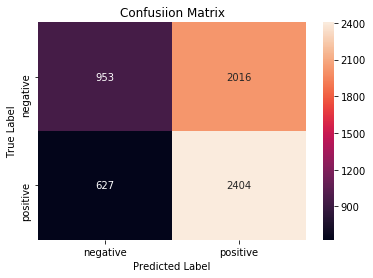

In [327]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_kd_avg_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [331]:
from prettytable import PrettyTable
x = PrettyTable()

K_kd_avg_w2v = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_kd_avg_w2v = np.around(100 - train_acc_kd_avg_w2v*100 , decimals = 2)
err_test_kd_avg_w2v =  np.around(100 - test_acc_kd_avg_w2v*100 , decimals = 2)
pre_kd_avg_w2v= np.around(pre_kd_avg_w2v, decimals = 2)
rec_kd_avg_w2v = np.around(rec_kd_avg_w2v, decimals = 2)
f1_kd_avg_w2v = np.around(f1_kd_avg_w2v, decimals = 2)
TPR = 2402
TNR = 953
FPR = 627
FNR =2016


x.add_row([cv,K_kd_avg_w2v,err_train_kd_avg_w2v,err_test_kd_avg_w2v,pre_kd_avg_w2v,rec_kd_avg_w2v,f1_kd_avg_w2v,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR  | TNR | FPR | FNR  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+
| cross_validation |    49   |      21.8      |     44.05     |    54.39     |   79.31   |    64.53    | 2402 | 953 | 627 | 2016 |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+------+-----+-----+------+


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

### CROSS VALIDATION TUNING
Simply using cross validation method to train and find the optimal value of k.
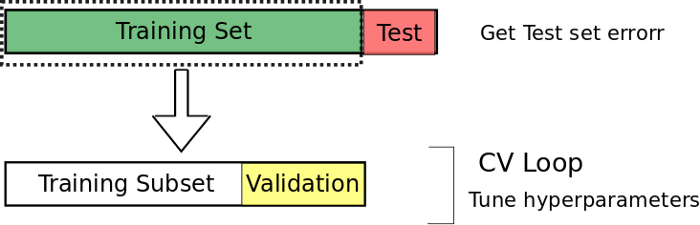

In [333]:
# finding optimal value of K.
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
roc_auc_kd_train_tfidf_w2v=[]
roc_auc_kd_cv_tfidf_w2v = []

k_range = list(filter(lambda x: x % 2 != 0,list(range(0,50))))   # taking odd values of k.

for i in k_range:
    
    knn_model_kd_tfidf_w2v  = KNeighborsClassifier(n_neighbors = i,algorithm = "kd_tree" )
    knn_model_kd_tfidf_w2v.fit(x_train_tfidf_w2v,y_train_brute.ravel())
    
    y_train_score = knn_model_tfidf_w2v.predict_proba(x_train_tfidf_w2v)[:,1]
    y_crossval_score = knn_model_tfidf_w2v.predict_proba(x_cv_tfidf_w2v)[:,1] #predictingrpobabilitty score for calculatinf ac and roc value.                

    roc_auc_kd_train_tfidf_w2v.append(roc_auc_score(y_train_brute,y_train_score))
    roc_auc_kd_cv_tfidf_w2v.append(roc_auc_score(y_cv_brute_tfidf,y_cv_score))                                                           
    
    #plottong graph between auc values and k valaues for both train and test
   
                                                          

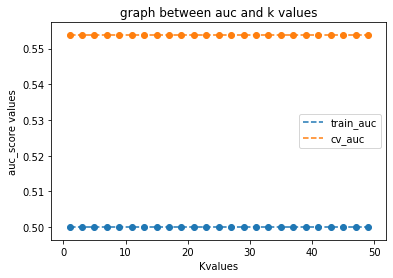

The best parameter is 1


In [334]:
  #plottong graph between auc values and k valaues for both train and test
plt.plot(k_range,roc_auc_kd_train_tfidf_w2v,label = "train_auc",linestyle = "dashed")
plt.scatter(k_range,roc_auc_kd_train_tfidf_w2v)
plt.plot(k_range,roc_auc_kd_cv_tfidf_w2v,label = "cv_auc", linestyle = "dashed")
plt.scatter(k_range,roc_auc_kd_cv_tfidf_w2v)
plt.xlabel("Kvalues")
plt.ylabel("auc_score values")
plt.title("graph between auc and k values")
plt.legend()
plt.show()

#getting best paramters using loops
auc_difference = []
for i in range(len(k_range)):
    auc_difference.append(roc_auc_kd_train_tfidf_w2v[i]-roc_auc_kd_cv_tfidf_w2v[i])
best_para = k_range[auc_difference.index(min(auc_difference))]   #list.index(a) gives  first index having value a.
print("The best parameter is",best_para)
                                                          

In [335]:
knn_kd_tfidf_w2v= neighbors.KNeighborsClassifier(n_neighbors = 1, algorithm = "kd_tree")
knn_kd_tfidf_w2v.fit(X_train_tfidf_w2v,Y_train_brute_tfidf.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### performance metrices

In [336]:
pred_tfidf_w2v = knn_kd_tfidf_w2v.predict(x_test_tfidf_w2v)
#train test accuracy
train_acc_kd_tfidf_w2v = knn_kd_tfidf_w2v.score(X_train_tfidf_w2v,Y_train_brute.ravel())
test_acc_kd_tfidf_w2v = knn_kd_tfidf_w2v.score(x_test_tfidf_w2v,y_test_brute)

#train test ROC value
y_scores_tfidf_w2v_train = knn_kd_tfidf_w2v.predict_proba(x_train_tfidf_w2v)
fpr,tpr,thresholds = roc_curve(y_train_brute,y_scores_tfidf_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc_kd_train_tfidf_w2v = auc(fpr,tpr)

y_scores_tfidf_w2v_test = knn_kd_tfidf_w2v.predict_proba(x_test_tfidf_w2v)
fpr_1,tpr_1,thresholds = roc_curve(y_test_brute,y_scores_tfidf_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc_kd_test_tfidf_w2v = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_kd_tfidf_w2v = precision_score(y_test_brute, pred_tfidf_w2v) * 100
rec_kd_tfidf_w2v = recall_score(y_test_brute, pred_tfidf_w2v) * 100
f1_kd_tfidf_w2v = f1_score(y_test_brute, pred_tfidf_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf_w2v*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf_w2v*100))
print("\nTrain ROC value=%f"% (roc_auc_kd_train_tfidf_w2v))
print("\nTest ROC value=%f"% (roc_auc_kd_test_tfidf_w2v))
print('\nprecision=%f%%' % (pre_kd_tfidf_w2v))
print('\nrecall=%f%%' % (rec_kd_tfidf_w2v))
print('\nF1-Score=%f%%' % (f1_kd_tfidf_w2v))


Train accuracy=50.221429%

Test accuracy=4.948333e+01% 

Train ROC value=0.500000

Test ROC value=0.500000

precision=50.516667%

recall=100.000000%

F1-Score=67.124349%


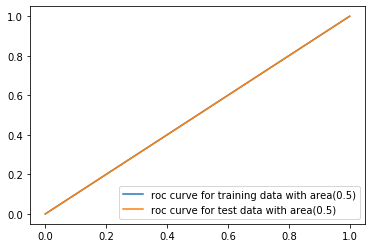

In [337]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training data with area({})".format(roc_auc_kd_train_tfidf_w2v))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_kd_test_tfidf_w2v))
plt.legend(loc="lower right")
plt.show()

In [338]:
pred_kd_tfidf_w2v = knn_kd_tfidf_w2v.predict(x_test_tfidf_w2v)
cm_kd_tfidf_w2v = confusion_matrix(y_test_brute_tfidf, pred_kd_tfidf_w2v)
cm_kd_tfidf_w2v

array([[   0, 2969],
       [   0, 3031]], dtype=int64)

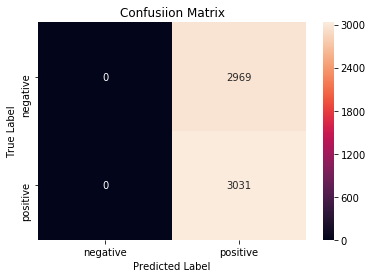

In [339]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_kd_tfidf_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [343]:
from prettytable import PrettyTable
x = PrettyTable()

K_kd_tfidf_w2v = best_para
cv = 'cross_validation'
x.field_names = ["CV","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","TPR","TNR","FPR","FNR"]


err_train_kd_tfidf_w2v = np.around(100 - train_acc_kd_tfidf*100 , decimals = 2)
err_test_kd_tfidf_w2v =  np.around(100 - test_acc_kd_tfidf*100 , decimals = 2)
pre_kd_tfidf_w2v= np.around(pre_kd_tfidf_w2v, decimals = 2)
rec_kd_tfidf_w2v = np.around(rec_kd_tfidf_w2v, decimals = 2)
f1_kd_tfidf_w2v = np.around(f1_kd_tfidf_w2v, decimals = 2)
TPR = 0
TNR = 2969
FPR = 3031
FNR =0


x.add_row([cv,K_kd_tfidf_w2v,err_train_kd_tfidf_w2v,err_test_kd_tfidf_w2v,pre_kd_tfidf_w2v,rec_kd_tfidf_w2v,f1_kd_tfidf_w2v,TPR,TNR,FPR,FNR])


print(x)

+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
|        CV        | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | TPR | TNR  | FPR  | FNR |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+
| cross_validation |    1    |     49.78      |     50.52     |    50.52     |   100.0   |    67.12    |  0  | 2969 | 3031 |  0  |
+------------------+---------+----------------+---------------+--------------+-----------+-------------+-----+------+------+-----+


In [344]:
from prettytable import PrettyTable
x = PrettyTable()


model1 = "kd_BOW"
model2 ="kd_TFIDF"
model3 = "kd_AVG_W2V"
model4 = "kd_TFIDF_W2V"
x.field_names = ["model","K_value","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)"]
x.add_row([model1,K_kd_bow,err_train_kd_bow,err_test_kd_bow,pre_kd_bow,rec_kd_bow,f1_kd_bow])
x.add_row([model2,K_kd_tfidf,err_train_kd_tfidf,err_test_kd_tfidf,pre_kd_tfidf,rec_kd_tfidf,f1_kd_tfidf])
x.add_row([model3,K_kd_avg_w2v,err_train_kd_avg_w2v,err_test_kd_avg_w2v,pre_kd_avg_w2v,rec_kd_avg_w2v,f1_kd_avg_w2v])
x.add_row([model4,K_kd_tfidf_w2v,err_train_kd_tfidf_w2v,err_test_kd_tfidf_w2v,pre_kd_tfidf_w2v,rec_kd_tfidf_w2v,f1_kd_tfidf_w2v])


print(x)

+--------------+---------+----------------+---------------+--------------+-----------+-------------+
|    model     | K_value | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------------+---------+----------------+---------------+--------------+-----------+-------------+
|    kd_BOW    |    47   |     30.93      |     35.33     |    78.74     |   35.09   |    48.54    |
|   kd_TFIDF   |    1    |     49.78      |     50.52     |     0.0      |    0.0    |     0.0     |
|  kd_AVG_W2V  |    49   |      21.8      |     44.05     |    54.39     |   79.31   |    64.53    |
| kd_TFIDF_W2V |    1    |     49.78      |     50.52     |    50.52     |   100.0   |    67.12    |
+--------------+---------+----------------+---------------+--------------+-----------+-------------+


# [6] Conclusions

1. The K-nearest neighbours for BOW, TFIDF, avg_w2v, tfidf_w2v are 47,1,49, and 1 respectively.<br>
2. The train and test error for TFIDF and TFDIF_w2v are much higher as compared to BOW and avg_w2v.<br>
3. True positive rate for both TFIDF and TFIDF_W2V based model  is zero i.e (number of positive reviews are predicted to be positive by our model) while True negative rate is 100. 
4. TFIDF and TFIDF_W2V based model is DUMB as AUC score for both model is approximatel 0.<br>




KNN AlGORITHM:
Kd-Tree and Brute Force are two different algorithms for finding nearest neighbors<br>
Time complexity of Kd-Tree is higher than Brute Force<br>
Feature importance for KNN algorithms can be found using Forward Feature selection or Backward Feature selection technique.<br>
We must take balance the dataset before modelling to prevent the model from under or overfitting.<br>
